In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC, SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#GETTING THE DATA
file_path = '/content/drive/My Drive/ML_data/ML_FinalProject/Finance_Datasets/dataset.csv'
dataset = pd.read_csv(file_path)

#PREPROCESSING

X = dataset.loc[:, ~dataset.columns.isin(['SPX','Date'])]
Y = dataset['SPX'].values

dataset

#Standard Normalization
scalerSS = StandardScaler()
X = scalerSS.fit_transform(X)

#Adding Cyclicality
time_cos = np.array([np.cos((pd.to_datetime(dataset['Date']).dt.month-1)*(2.*np.pi/12))],dtype=np.float_).T
X = np.concatenate((X,time_cos),axis=1)

#Split Data
np.random.seed(17)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size = 0.7, test_size = 0.3, random_state = 100)

#Create Tensors
Y_train = torch.from_numpy(np.resize(Y_train,[len(Y_train),1])).to(torch.float32)
X_train = torch.from_numpy(X_train).to(torch.float32)
Y_test = torch.from_numpy(np.resize(Y_test,[len(Y_test),1])).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)


#Model
seq_model=nn.Sequential(nn.Linear(59,30),nn.Tanh(),nn.Linear(30,15),nn.Tanh(),nn.Linear(15,1))
optimizer = optim.Adam(seq_model.parameters(),lr=0.00001)



epochs=2000
loss_fn=nn.BCELoss()
loss_df = pd.DataFrame(columns=['Epoch','Training Loss','Validation Loss'])



for epoch in range(1,epochs +1):
    train = torch.sigmoid(seq_model(X_train))
    loss_train =loss_fn(train,Y_train)

    val = torch.sigmoid(seq_model(X_test))
    loss_val = loss_fn(val,Y_test)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    loss_data= {'Epoch':epoch,'Training Loss':loss_train.detach().numpy(),'Validation Loss':loss_val.detach().numpy()}
    append_data = pd.DataFrame(data=loss_data,index=[epoch])
    loss_df = pd.concat([loss_df,append_data])

    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {loss_train.item():.10f},"f" Validation loss {loss_val.item():.10f}")


Epoch 1, Training loss 0.7207291126, Validation loss 0.7258562446
Epoch 10, Training loss 0.7204408050, Validation loss 0.7257204652
Epoch 20, Training loss 0.7201210856, Validation loss 0.7255709767
Epoch 30, Training loss 0.7198023796, Validation loss 0.7254235148
Epoch 40, Training loss 0.7194843888, Validation loss 0.7252787352
Epoch 50, Training loss 0.7191670537, Validation loss 0.7251372337
Epoch 60, Training loss 0.7188506722, Validation loss 0.7249988914
Epoch 70, Training loss 0.7185347676, Validation loss 0.7248635888
Epoch 80, Training loss 0.7182196379, Validation loss 0.7247309089
Epoch 90, Training loss 0.7179049253, Validation loss 0.7246007919
Epoch 100, Training loss 0.7175907493, Validation loss 0.7244730592
Epoch 110, Training loss 0.7172771096, Validation loss 0.7243475318
Epoch 120, Training loss 0.7169637680, Validation loss 0.7242239714
Epoch 130, Training loss 0.7166507244, Validation loss 0.7241024971
Epoch 140, Training loss 0.7163381577, Validation loss 0.72

Accuracy:  0.5
Recall:  0.4528301886792453
Precision:  0.6666666666666666
F1:  0.5393258426966292


Text(0.5, 427.9555555555555, 'Predicted label')

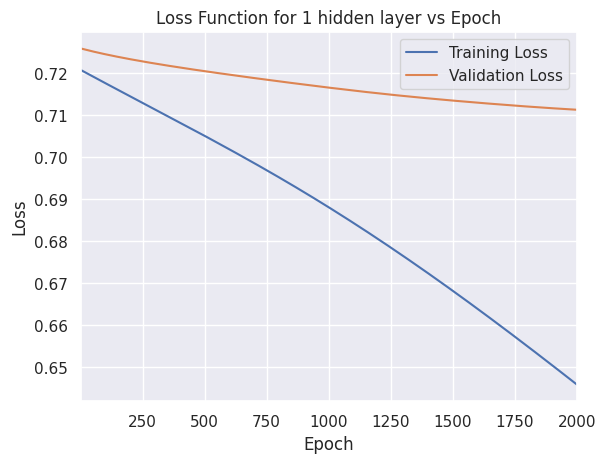

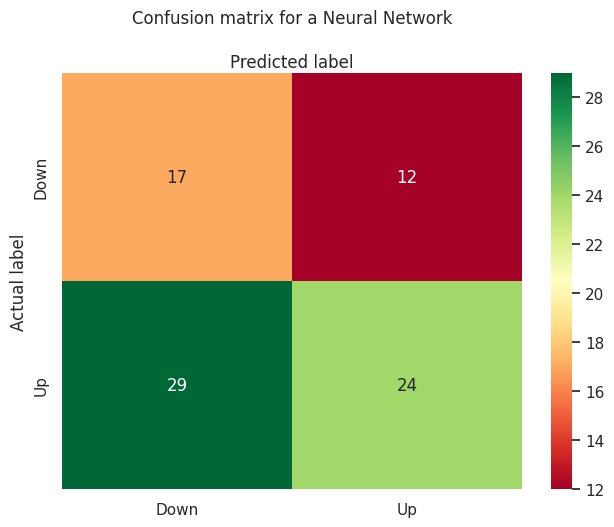

In [12]:

numel_list = [p.numel() for p in seq_model.parameters()]
sum(numel_list) , numel_list

#Plot loss over epoch
fig, ax = plt.subplots()
ax.plot(loss_df['Training Loss'])
ax.plot(loss_df['Validation Loss'])
ax.legend(['Training Loss','Validation Loss'])
ax.set_title('Loss Function for 1 hidden layer vs Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xlim(1,epochs)

#Create Probability from Regression
Y_logits = seq_model(X_test)
Y_pred = torch.sigmoid(Y_logits)
Y_pred = torch.round(Y_pred).detach().numpy()

#Stats
from sklearn import metrics
accuracy = metrics.accuracy_score(Y_test, Y_pred)
precision = metrics.precision_score(Y_test, Y_pred)
recall = metrics.recall_score(Y_test, Y_pred)
f1 = metrics.f1_score(Y_test, Y_pred)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F1: ", f1)


# Confusion Matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(Y_test, Y_pred)
cnf_matrix

#Plot Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
class_names=['Down','Up'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.array([.5,1.5])

# create heatmap
sns.heatmap(cnf_matrix, annot=True, cmap="RdYlGn" ,fmt='g')
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix for a Neural Network', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')